In [1]:
# General imports
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import optuna
import uuid

# Sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

# Keras imports
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Tensorflow Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, BatchNormalization, Attention
from tensorflow.keras.optimizers import Adam

# Import library with current code functions
sys.path.append(os.path.join(".", "lib"))
import neural_network_functions as neural_net_fun


In [2]:
# Check if TensorFlow can find the GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print("TensorFlow found the following GPU(s):")
    for device in physical_devices:
        print(device)
else:
    print("No GPU found. TensorFlow is running on the CPU.")

No GPU found. TensorFlow is running on the CPU.


## Functions

### Pre-process data

In [3]:
# Load and clean the dataset
def load_and_clean_dataset(dataset_path):
    SEQUENCES = pd.read_csv(dataset_path)

    if 'Unnamed: 0' in SEQUENCES.columns:
        SEQUENCES.drop(columns=['Unnamed: 0'], inplace=True)
    return SEQUENCES

# Filter emotions based on a query
def filter_emotions(SEQUENCES, emotions_query):
    return SEQUENCES.query(emotions_query)

# Encode labels into numerical values
def encode_labels(SEQUENCES_ENCODED):
    encoder = LabelEncoder()
    SEQUENCES_ENCODED['label_numerical'] = encoder.fit_transform(SEQUENCES_ENCODED['label'])
    label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    print("Label Mapping:", label_mapping)
    return SEQUENCES_ENCODED, label_mapping

# Select features
def select_features(SEQUENCES_ENCODED):
    features = SEQUENCES_ENCODED.columns.to_list()[4:25]
    print(f"Features being used: {features}")
    n_features = len(features)
    len_sample_max = SEQUENCES_ENCODED.sample_id.value_counts().max()
    return features, n_features, len_sample_max

# Pad sequences
def pad_sequences(SEQUENCES_ENCODED, features, len_sample_max):
    grouped_data = []
    for sample_id, group in SEQUENCES_ENCODED.groupby('sample_id'):
        sequence_features = group[features]
        if len(sequence_features) < len_sample_max:
            N_rows = len_sample_max - len(sequence_features)
            pad = pd.DataFrame(np.zeros((N_rows, len(features))), columns=sequence_features.columns)
            sequence_features_pad = pd.concat([pad, sequence_features], ignore_index=True)
        else:
            sequence_features_pad = sequence_features
        label = SEQUENCES_ENCODED[SEQUENCES_ENCODED.sample_id == sample_id].iloc[0].label_numerical
        grouped_data.append((sequence_features_pad, label))

    X = np.array([item[0] for item in grouped_data])
    Y = np.array([item[1] for item in grouped_data])
    return X, Y

# Normalize data (using external function)
def normalize_data(X_balanced):
    return neural_net_fun.normalize_data(X_balanced)

# Split data into train, validation, and test sets
def split_data(X, Y, train_size=0.7, val_size=0.15, test_size=0.15):
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, random_state=42, shuffle=True)
    val_relative_size = val_size / (train_size + val_size)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=val_relative_size, stratify=Y_train_val, random_state=42, shuffle=True)

    Y_train = Y_train.reshape(-1, 1)
    Y_val = Y_val.reshape(-1, 1)
    Y_test = Y_test.reshape(-1, 1)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

# Perform augmentation based on groups of sample_id
def perform_augmentation(SEQUENCES_ENCODED, features, emotions_augmentation_factors):
    augmented_data = []
    for sample_id, group in SEQUENCES_ENCODED.groupby('sample_id'):
        emotion = group['label'].iloc[0]
        label_numerical = group['label_numerical'].iloc[0]
        sequence_features = group[features]

        # Add the original group
        augmented_data.append((sample_id, sequence_features.values, label_numerical))

        # Augment only if the emotion is in the specified list
        if emotion in list(emotions_augmentation_factors.keys()):
            augmentation_factor = emotions_augmentation_factors.get(emotion, 1.0)
            augment_general_chance = augmentation_factor - 1
            augment_current_series_chance = random.random()

            if augment_current_series_chance <= augment_general_chance:
                # Augmentation technique 1: Add Gaussian noise
                noise = np.random.normal(0, 0.01, size=sequence_features.shape)
                augmented_group = sequence_features + noise

                # Create a new sample_id for the augmented group
                new_sample_id = f"{sample_id}_aug_{uuid.uuid4().hex[:8]}"

                # Append the augmented group
                augmented_data.append((new_sample_id, augmented_group, label_numerical))
    
        # Inicializar o DataFrame vazio com as colunas corretas
    augmented_df = pd.DataFrame(columns=['sample_id'] + features + ['label_numerical'])

    # Iterar sobre os dados aumentados
    for sample_id, features_series, label_numerical in augmented_data:
        # Criar um DataFrame temporário para cada item
        temp_df = pd.DataFrame(features_series, columns=features)
        temp_df['sample_id'] = sample_id  # Adicionar o sample_id a todas as linhas
        temp_df['label_numerical'] = label_numerical  # Adicionar o label a todas as linhas

        # Concatenar o DataFrame temporário ao final
        augmented_df = pd.concat([augmented_df, temp_df], ignore_index=True)

    return augmented_df

# Main preprocessing function
def preprocess_data_current_dataset(dataset_path, emotions, emotions_augmentation_factors=None, train_size=0.7, val_size=0.15, test_size=0.15):
    SEQUENCES = load_and_clean_dataset(dataset_path)
    SEQUENCES = filter_emotions(SEQUENCES, emotions)

    SEQUENCES_ENCODED, label_mapping = encode_labels(SEQUENCES)
    features, n_features, len_sample_max = select_features(SEQUENCES_ENCODED)
    timesteps = len_sample_max
    n_classes = len(label_mapping)

    # Perform augmentation
    if emotions_augmentation_factors:
        SEQUENCES_ENCODED_BEFORE = SEQUENCES_ENCODED.copy()  # Save original for comparison
        SEQUENCES_ENCODED = perform_augmentation(SEQUENCES_ENCODED, features, emotions_augmentation_factors)

    # Padding happens after augmentation
    X, Y = pad_sequences(SEQUENCES_ENCODED, features, len_sample_max)
    
    X_complete = normalize_data(X)

    X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X_complete, Y, train_size, val_size, test_size)

    return {
        'label_mapping': label_mapping,
        'timesteps': timesteps,
        'n_classes': n_classes,
        'n_features': n_features,
        'X_complete': X_complete,
        'Y_complete': Y,
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'Y_train': Y_train,
        'Y_val': Y_val,
        'Y_test': Y_test,
        'SEQUENCES_BEFORE': SEQUENCES_ENCODED_BEFORE,  # Data before augmentation
        'SEQUENCES_AFTER': SEQUENCES_ENCODED           # Data after augmentation
    }


In [4]:
def checking_data(label_mapping, timesteps, n_classes, n_features, X_complete, Y_complete, X_train, X_val, X_test, Y_train, Y_val, Y_test):
    print("===== Data Information =====")
    print(f"Timesteps: {timesteps}")
    print(f"Number of classes: {n_classes}")
    print(f"Number of features: {n_features}")
    
    print("\n===== Label Mapping =====")
    for label, numerical_value in label_mapping.items():
        print(f"'{label}' -> {numerical_value}")

    print("\n===== Data Summary =====")
    print(f"Shape of X: {X_complete.shape}")
    print(f"Shape of Y: {Y_complete.shape}")
    print("Sample count per class:")
    for numerical_value, count in enumerate(np.bincount(Y_complete)):
        label = list(label_mapping.keys())[list(label_mapping.values()).index(numerical_value)]
        print(f"Class '{label}' (Value {numerical_value}): {count} samples")
    
    print("\n===== Training Set =====")
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of Y_train: {Y_train.shape}")

    train_counts = np.bincount(Y_train.flatten())
    for numerical_value, count in enumerate(train_counts):
        label = list(label_mapping.keys())[list(label_mapping.values()).index(numerical_value)]
        print(f"Class '{label}' (Value {numerical_value}): {count} samples")

    print("\n===== Validation Set =====")
    print(f"Shape of X_val: {X_val.shape}")
    print(f"Shape of Y_val: {Y_val.shape}")

    train_counts = np.bincount(Y_val.flatten())
    for numerical_value, count in enumerate(train_counts):
        label = list(label_mapping.keys())[list(label_mapping.values()).index(numerical_value)]
        print(f"Class '{label}' (Value {numerical_value}): {count} samples")
    
    print("\n===== Test Set =====")
    print(f"Shape of X_test: {X_test.shape}")
    print(f"Shape of Y_test: {Y_test.shape}")

    test_counts = np.bincount(Y_test.flatten())
    for numerical_value, count in enumerate(test_counts):
        label = list(label_mapping.keys())[list(label_mapping.values()).index(numerical_value)]
        print(f"Class '{label}' (Value {numerical_value}): {count} samples")

### Model functions

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalização e Atenção Multi-Cabeça
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs # Conexão residual

    # Parte Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x) # Garante que a saída tenha a mesma dimensão da entrada para a próxima conexão residual
    return x + res # Conexão residual final

In [7]:
def define_transformer_model(timesteps, num_features, num_classes,
                             head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout_mlp,
                             learning_rate):
    inputs = keras.Input(shape=(timesteps, num_features))
    x = inputs

    # Adiciona múltiplos blocos Transformer
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout=dropout_mlp)

    # Pooling para reduzir a sequência a um vetor de características fixo
    # 'channels_last' é o padrão para dados de sequência (batch, timesteps, features)
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)

    # Camadas MLP (Dense) para classificação
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout_mlp)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x) # Saída para classificação multi-classe

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy", # Adequado para one-hot encoded labels
        metrics=["accuracy"],
    )
    return model

In [8]:
def training_process_transformer(timesteps, n_classes, n_features, X_train, X_val, Y_train, Y_val, model_parameters, batch_size, epochs):
    # Cria o modelo Transformer com os parâmetros fornecidos
    model = define_transformer_model(timesteps, n_features, n_classes,
                                     model_parameters['head_size'],
                                     model_parameters['num_heads'],
                                     model_parameters['ff_dim'],
                                     model_parameters['num_transformer_blocks'],
                                     model_parameters['mlp_units'],
                                     model_parameters['dropout_mlp'],
                                     model_parameters['learning_rate'])
    patience = 17 # Paciência para Early Stopping

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Converter Y_train e Y_val para one-hot encoding, se ainda não estiverem
    Y_train_one_hot = to_categorical(Y_train, n_classes)
    Y_val_one_hot = to_categorical(Y_val, n_classes)

    from keras.callbacks import ReduceLROnPlateau # Garanta que está importado aqui ou no início do notebook
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

    # Treinar o modelo
    history = model.fit(
        X_train, Y_train_one_hot,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val_one_hot),
        callbacks=[early_stopping, reduce_lr] # Adicionado reduce_lr
    )

    return history, model

In [9]:
def evaluate_model_performance(model, X_train, y_train, X_test, y_test, class_labels):
    # Número de classes
    num_classes = len(class_labels)
    
    # Convert y_train e y_test para codificação one-hot
    y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
    y_test_one_hot = to_categorical(y_test, num_classes=num_classes)
    
    # Obter probabilidades preditas
    y_train_pred_proba = model.predict(X_train)
    y_test_pred_proba = model.predict(X_test)
    
    # Obter classes preditas (classe com a maior probabilidade)
    y_train_pred = np.argmax(y_train_pred_proba, axis=1)
    y_test_pred = np.argmax(y_test_pred_proba, axis=1)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    
    # Imprimir métricas
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    
    # Plotar matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular ROC AUC para cada classe
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_test_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test_one_hot[:, i], y_test_pred_proba[:, i])
    
    # Plotar curvas ROC para cada classe
    plt.figure()
    colors = plt.cm.get_cmap('tab10', num_classes)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()
    
    return accuracy, precision, recall, f1, conf_matrix

In [10]:
def plot_learning_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history.history['accuracy']), 5))  # Set x-axis ticks every 5 epochs
    plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
    plt.title('Model Accuracy')

    # Plot training & validation loss values (linear scale)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'][:60], label='Training Loss (Linear)', color='blue')
    plt.plot(history.history['val_loss'][:60], label='Validation Loss (Linear)', color='orange')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0,)  # Automatically scale the y-axis starting at 0
    plt.xticks(range(0, len(history.history['loss']), 5))  # Set x-axis ticks every 5 epochs
    plt.legend(loc='upper left')
    plt.title('Model Loss')

    # Add log-scale loss in the same plot
    plt.twinx()  # Create a secondary y-axis sharing the same x-axis
    plt.plot(history.history['loss'][:60], linestyle='--', color='blue', alpha=0.7, label='Training Loss (Log)')
    plt.plot(history.history['val_loss'][:60], linestyle='--', color='orange', alpha=0.7, label='Validation Loss (Log)')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.ylabel('Loss (Log Scale)')
    plt.legend(loc='upper right')

    #plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


In [11]:
def show_data_before_augment(data):
    # Agregar por `sample_id` e manter apenas a primeira ocorrência do `label` por ID
    aggregated_data = data.groupby('sample_id').first()

    # Contar a quantidade de cada emoção (label)
    emotion_counts = aggregated_data['label'].value_counts()

    # Quantidade total de amostras únicas por sample_id
    total_count = len(aggregated_data)

    print("Quantidade de cada emoção ANTES DO AUGMENT (agregado por sample_id):")
    print(emotion_counts)
    print("\nQuantidade total (sample_id únicos):", total_count)


## Getting data

In [12]:
SEQUENCES_NAME_FILE = fr'C:\Users\Nilton\OneDrive\Área de Trabalho\PROT-D\07 - Neural Network\result_sequences\DATASET_SEQUENCES_6.CSV'

In [13]:
# All words - aleatorio 'random' or 'others' || 'interview'
emotions = ['aleatorio', 'interview', 'have', 'about']

# Building the query with the emotions
emotions_query = " | ".join([f"label == '{emotion}'" for emotion in emotions])

emotions_augmentation_factors = {
    'aleatorio': 1.2,  # Aumentar em 30%
    'interview': 1.6,
    'have': 1.4,
    'about': 1.5
}
data_info = preprocess_data_current_dataset(
        SEQUENCES_NAME_FILE, 
        emotions = emotions_query,
        emotions_augmentation_factors=emotions_augmentation_factors
    )

# Agora você pode acessar cada item no dicionário 'data_info' usando as chaves
label_mapping = data_info['label_mapping']
timesteps = data_info['timesteps']
n_classes = data_info['n_classes']
n_features = data_info['n_features']

X_complete = data_info['X_complete']
Y_complete = data_info['Y_complete']

X_train = data_info['X_train']
X_val = data_info['X_val']
X_test = data_info['X_test']

Y_train = data_info['Y_train']
Y_val = data_info['Y_val']
Y_test = data_info['Y_test']

SEQUENCES_BEFORE = data_info['SEQUENCES_BEFORE']
SEQUENCES_AFTER = data_info['SEQUENCES_AFTER']


Label Mapping: {'about': 0, 'aleatorio': 1, 'have': 2, 'interview': 3}
Features being used: ['m3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'e1', 'e2', 'e3', 'b1', 'b2', 'b3']


In [14]:
show_data_before_augment(SEQUENCES_BEFORE)

Quantidade de cada emoção ANTES DO AUGMENT (agregado por sample_id):
label
about        57
aleatorio    55
interview    55
have         53
Name: count, dtype: int64

Quantidade total (sample_id únicos): 220


In [15]:
checking_data(label_mapping, timesteps, n_classes, n_features, X_complete, Y_complete, X_train, X_val, X_test, Y_train, Y_val, Y_test)

===== Data Information =====
Timesteps: 37
Number of classes: 4
Number of features: 21

===== Label Mapping =====
'about' -> 0
'aleatorio' -> 1
'have' -> 2
'interview' -> 3

===== Data Summary =====
Shape of X: (318, 37, 21)
Shape of Y: (318,)
Sample count per class:
Class 'about' (Value 0): 87 samples
Class 'aleatorio' (Value 1): 67 samples
Class 'have' (Value 2): 78 samples
Class 'interview' (Value 3): 86 samples

===== Training Set =====
Shape of X_train: (222, 37, 21)
Shape of Y_train: (222, 1)
Class 'about' (Value 0): 61 samples
Class 'aleatorio' (Value 1): 47 samples
Class 'have' (Value 2): 54 samples
Class 'interview' (Value 3): 60 samples

===== Validation Set =====
Shape of X_val: (48, 37, 21)
Shape of Y_val: (48, 1)
Class 'about' (Value 0): 13 samples
Class 'aleatorio' (Value 1): 10 samples
Class 'have' (Value 2): 12 samples
Class 'interview' (Value 3): 13 samples

===== Test Set =====
Shape of X_test: (48, 37, 21)
Shape of Y_test: (48, 1)
Class 'about' (Value 0): 13 samples


## Tunning

In [16]:
#batch_size = 16

# Getting the best hyperparameters
#study = optuna.create_study(direction='maximize')
#study.optimize(lambda trial: objective(trial, timesteps, n_classes, n_features, X_complete, Y_complete, batch_size=batch_size), n_trials=20)
#print("Best params found:", study.best_params)

## Training

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.2546 - loss: 1.4280 - val_accuracy: 0.4167 - val_loss: 1.2894 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4520 - loss: 1.2625 - val_accuracy: 0.5208 - val_loss: 1.1933 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4845 - loss: 1.1713 - val_accuracy: 0.5417 - val_loss: 1.0178 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5829 - loss: 1.0013 - val_accuracy: 0.5833 - val_loss: 0.9038 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6024 - loss: 0.9486 - val_accuracy: 0.6667 - val_loss: 0.8128 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6560 - loss: 0.8358 - val_accuracy: 0.6250 - val_loss: 0.7747 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6539 - loss: 0.8127 - 

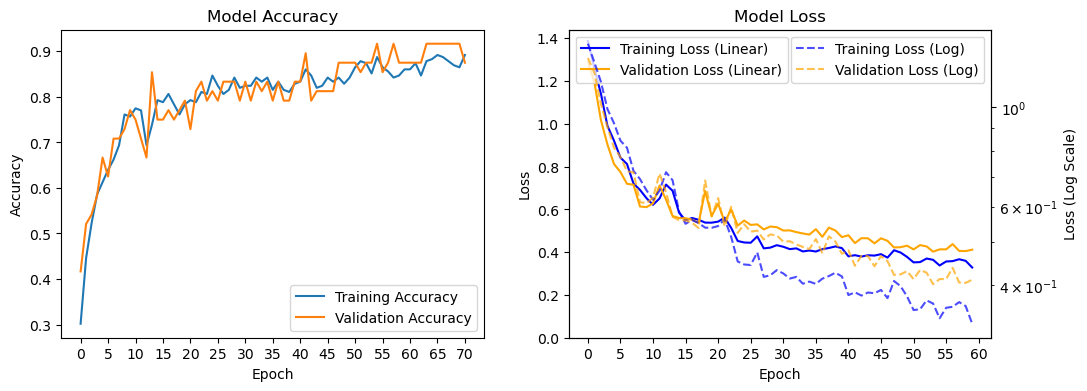

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Accuracy: 0.81
Precision: 0.82
Recall: 0.81
F1-Score: 0.81


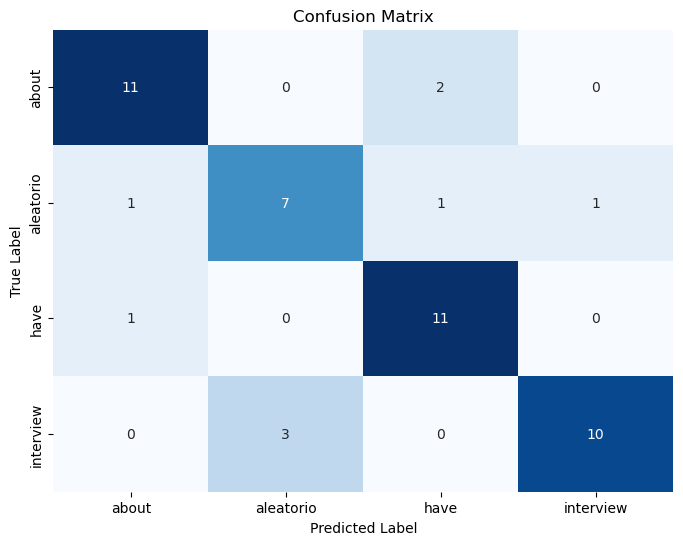

C:\Users\Nilton\AppData\Local\Temp\ipykernel_3868\2919547274.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


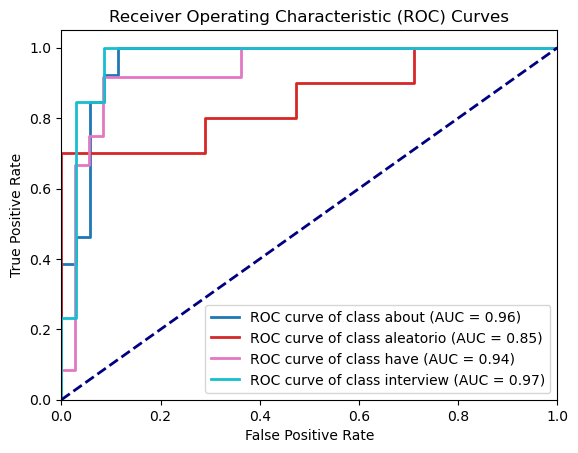

In [17]:
# Se você executou o Optuna para o transformer, use study.best_params aqui.
# Exemplo: best_params_transformer = study.best_params

# Parâmetros padrão para o modelo Transformer, caso não execute o Optuna
best_params_transformer = {
    'head_size': 64,                 # Reduzido de 128
    'num_heads': 2,                  # Reduzido de 4
    'ff_dim': 128,                   # Reduzido de 256
    'num_transformer_blocks': 1,     # Reduzido de 2
    'mlp_units': [64],               # MLP mais simples: [128, 64] -> [64]
    'dropout_mlp': 0.25,             # Aumentado de 0.2
    'learning_rate': 0.001           # Mantido, mas ReduceLROnPlateau ajudará
}

batch_size = 16 # Mantenha como no notebook original
epochs = 100 # Mantenha como no notebook original (Early Stopping irá parar antes se houver convergência)

# Chame a nova função de treinamento para o Transformer
history, model = training_process_transformer(timesteps, n_classes, n_features,
                                             X_train, X_val, Y_train, Y_val,
                                             best_params_transformer, batch_size=batch_size, epochs=epochs)

# Plote as curvas de aprendizado
plot_learning_curves(history)

# Avalie o desempenho do modelo
evaluate_model_performance(model, X_train, Y_train, X_test, Y_test, class_labels=list(label_mapping.keys()))

# Salve o modelo no formato .keras, que é mais compatível para implantação com TF/Keras
model.save('transformer_model_for_' + str(len(emotions)) + "_emotions.keras")

## Evaluating

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Accuracy: 0.81
Precision: 0.82
Recall: 0.81
F1-Score: 0.81


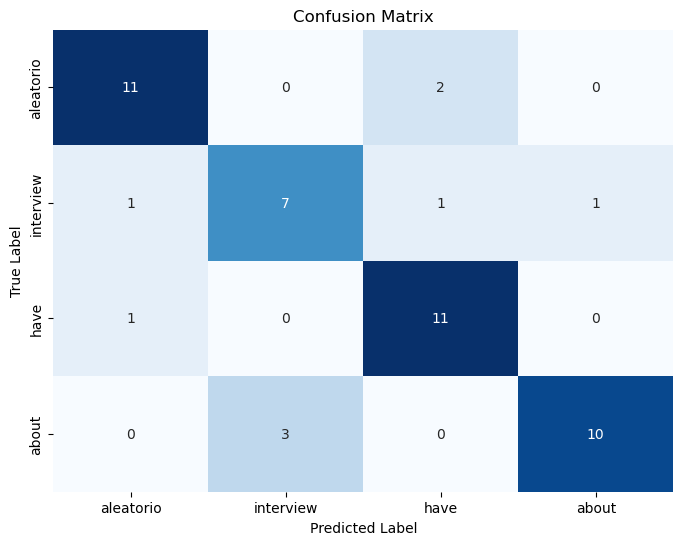

C:\Users\Nilton\AppData\Local\Temp\ipykernel_3868\2919547274.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


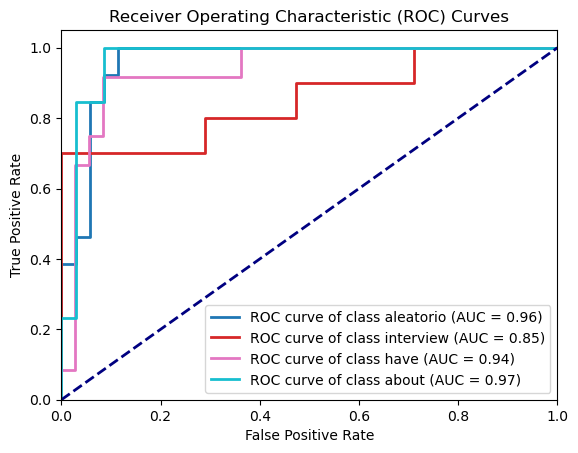

(0.8125,
 0.8176406926406927,
 0.8125,
 0.812232905982906,
 array([[11,  0,  2,  0],
        [ 1,  7,  1,  1],
        [ 1,  0, 11,  0],
        [ 0,  3,  0, 10]], dtype=int64))

In [18]:
evaluate_model_performance(model, X_train, Y_train, X_test, Y_test, class_labels=emotions)

In [20]:
# Saving the model
model.save("transformer_model_for_protD.keras")